In [6]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [7]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [8]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1904
Number of these with 4 images =  260
Number of these with i3 < 22 =  114


OM10: Extracted OM10 lens number 4374291:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
4374291        0    2  0.46 ...         23.87 23.6557388199 24.2225716205
galaxy_x, galaxy_y, PSF_HWHM:
multiplication factor :  2.32525940274e-06
108.548123567
PSF_sigma:  0.727005
currLensX:  0.7731 currLensY:  -0.2928
multiplication factor :  108.548123567
1.17381514196
PSF_sigma:  0.727005
currLensX:  -1.7766 currLensY:  0.6599
multiplication factor :  1.17381514196
#####################BEFORE DEBLEND PLOT LENSES##################################


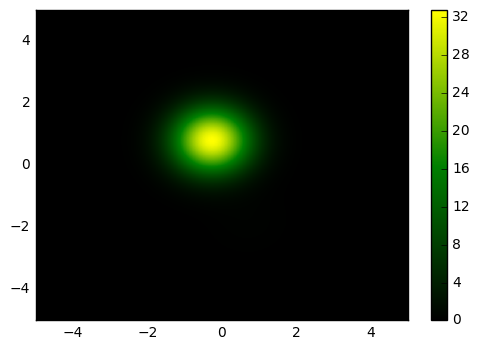

This is the covariance I calculated:  [[ 5381.42334844  -257.08450916]
 [ -257.08450916  5973.38510573]]
This is the eigenvalue I have (array([ 5285.36197761,  6069.44647656]), array([[-0.9367422 , -0.35002008],
       [-0.35002008,  0.9367422 ]]))
standard deviation is:  72.70049503
standard deviation is:  77.9066523255


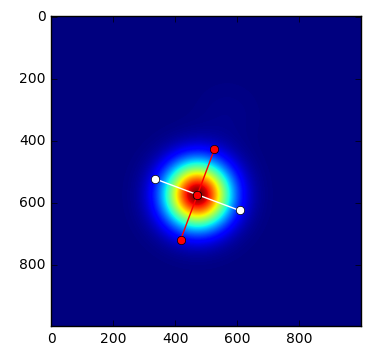

**************zeroth moment:  1097219.35421
**************first moment:  -0.282607968982 0.74582333422
**************second moment:  [[ 5381.42334844  -257.08450916]
 [ -257.08450916  5973.38510573]]
#####################PRINTING NULL DEBLENDER'S PLOT###############################


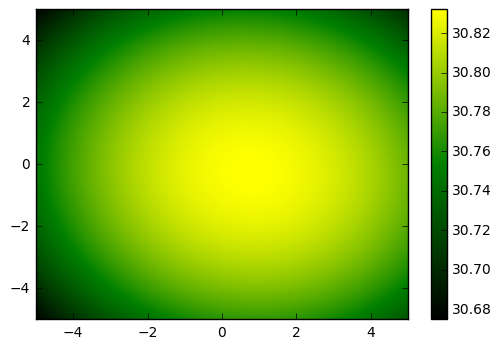

###############################################################################
('chi squared: ', 0.13714083292292814, 'p: ', 1.0)
('Chi squared distance is : ', (0.13714083292292814, 1.0))
('KL distance is : ', 9.7561394214869495)


In [10]:
realizer.deblend(lensID=k, version=1, null_deblend=True, debug=True, show_plot=True)